In [1]:
import tensorflow.keras.backend as K
import multiprocessing

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import csv
import math
import random
import logging

import tf_glove
# https://github.com/GradySimon/tensorflow-glove/blob/master/tf_glove.py

from nltk.stem.lancaster import LancasterStemmer
from nltk.tokenize import RegexpTokenizer

In [2]:
# Set random seed (for reproducibility)
np.random.seed(1000)

In [3]:
#dataset_location = './datasets/sarcasm_v2.csv'
dataset_location = './datasets/text_and_annorations.csv'

corpus = []
labels = []

In [4]:
#Shuffle the dataset

ip=open(dataset_location,'r', encoding="utf8")
next(ip)   #ignore the first row (label row)
li = ip.readlines()
random.shuffle(li)

#dataset_location = './datasets/shuffled_sarcasm_v2.csv'
dataset_location = './datasets/shuffled_text_and_annotations.csv'

fid = open(dataset_location, "w", encoding="utf8")
fid.writelines(li)
fid.close()

In [5]:
# Parse tweets and sentiments       
with open(dataset_location, 'r', encoding="utf8") as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    
    #skip the first line?
    #next(csvReader)
    
    for row in csvReader:
        #corpus.append(row[3] + " - " + row[4])
        corpus.append(row[1])

        #Sarcasm label, (0 = not sarcasm, 1 = sarcasm)
        #pol = 1 if row[1] == 'sarc' else 0
        pol = 1 if row[5] == 'Yes' else 0
        labels.append(pol)
        
print('Corpus size: {}'.format(len(corpus)))

Corpus size: 994


In [6]:
# Tokenize and stem
tkr = RegexpTokenizer('[a-zA-Z0-9@]+')
stemmer = LancasterStemmer()

tokenized_corpus = []

for i, tweet in enumerate(corpus):
    tokens = [stemmer.stem(t) for t in tkr.tokenize(tweet) if not t.startswith('@')]
    #tokens = [t for t in tkr.tokenize(tweet) if not t.startswith('@')]
    tokenized_corpus.append(tokens)

In [7]:
vector_size = 200
window_size = 10

In [8]:
# Create GloVe embeddings
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

model = tf_glove.GloVeModel(embedding_size=vector_size, context_size=window_size)
model.fit_to_corpus(tokenized_corpus)
model.train(num_epochs=100)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2020-05-16 16:06:15,954 : WARNING : From C:\Users\rbn\Anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1635: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


2020-05-16 16:06:15,993 : WARNING : From C:\Users\rbn\Documents\Python Scripts\tf_glove.py:96: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Use `tf.cast` instead.


2020-05-16 16:06:16,001 : WARNING : From C:\Users\rbn\Documents\Python Scripts\tf_glove.py:101: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2020-05-16 16:06:16,077 : WARNING : From C:\Users\rbn\Anaconda3\lib\site-packages\tensorflow_core\python\training\adagrad.py:76: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
X_vecs = model
del corpus

In [10]:
# Train subset size (0 < size < len(tokenized_corpus))
train_size = math.floor(0.8 * len(tokenized_corpus))

# Test subset size (0 < size < len(tokenized_corpus) - train_size)
test_size = len(tokenized_corpus) - train_size

# Compute average and max tweet length
avg_length = 0.0
max_length = 0

for tweet in tokenized_corpus:
    if len(tweet) > max_length:
        max_length = len(tweet)
    avg_length += float(len(tweet))
    
print('Average tweet length: {}'.format(avg_length / float(len(tokenized_corpus))))
print('Max tweet length: {}'.format(max_length))

Average tweet length: 23.5523138832998
Max tweet length: 201


In [11]:
# Tweet max length (number of tokens)
max_tweet_length = max_length

In [12]:
# Create train and test sets
# Generate random indexes
indexes = set(np.random.choice(len(tokenized_corpus), train_size + test_size, replace=False))

X_train = np.zeros((train_size, max_tweet_length, vector_size), dtype=K.floatx())
Y_train = np.zeros((train_size, 2), dtype=np.int32)
X_test = np.zeros((test_size, max_tweet_length, vector_size), dtype=K.floatx())
Y_test = np.zeros((test_size, 2), dtype=np.int32)

for i, index in enumerate(indexes):
    for t, token in enumerate(tokenized_corpus[index]):
        if t >= max_tweet_length:
            break

    
        if i < train_size:
            X_train[i, t, :] = X_vecs.embedding_for(token)
        else:
            X_test[i - train_size, t, :] = X_vecs.embedding_for(token)
            
    if i < train_size:
        Y_train[i, :] = [1.0, 0.0] if labels[index] == 0 else [0.0, 1.0]
    else:
        Y_test[i - train_size, :] = [1.0, 0.0] if labels[index] == 0 else [0.0, 1.0] 

In [13]:
batch_size = 16
nb_epochs = 15

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, input_shape=(max_tweet_length, vector_size)))
model.add(tf.keras.layers.LSTM(128, return_sequences='true'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 201, 64)           12864     
_________________________________________________________________
lstm (LSTM)                  (None, 201, 128)          98816     
_________________________________________________________________
flatten (Flatten)            (None, 25728)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 51458     
Total params: 163,138
Trainable params: 163,138
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [15]:
# Fit the model
history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          shuffle=True,
          epochs=nb_epochs,
          validation_data=(X_test, Y_test))

Train on 795 samples, validate on 199 samples
Epoch 1/15
795/795 [==============================] - 12s 15ms/sample - loss: 0.6454 - accuracy: 0.6189 - val_loss: 0.5827 - val_accuracy: 0.6935
Epoch 2/15
795/795 [==============================] - 8s 11ms/sample - loss: 0.5952 - accuracy: 0.6553 - val_loss: 0.5621 - val_accuracy: 0.7588
Epoch 3/15
795/795 [==============================] - 8s 11ms/sample - loss: 0.5389 - accuracy: 0.7811 - val_loss: 0.5281 - val_accuracy: 0.7688
Epoch 4/15
795/795 [==============================] - 8s 11ms/sample - loss: 0.4847 - accuracy: 0.8189 - val_loss: 0.5339 - val_accuracy: 0.7739
Epoch 5/15
795/795 [==============================] - 9s 11ms/sample - loss: 0.4534 - accuracy: 0.8566 - val_loss: 0.5492 - val_accuracy: 0.7487
Epoch 6/15
795/795 [==============================] - 9s 11ms/sample - loss: 0.4547 - accuracy: 0.8503 - val_loss: 0.5252 - val_accuracy: 0.7789
Epoch 7/15
795/795 [==============================] - 8s 11ms/sample - loss: 0.4295

In [16]:
loss, accuracy = model.evaluate(X_test, Y_test)

print("Loss: ", "%.3f" % loss)
print("Accuracy: ", "%.3f" % accuracy)

199/199 [==============================] - 0s 2ms/sample - loss: 0.5270 - accuracy: 0.7638
Loss:  0.527
Accuracy:  0.764


# Graph

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

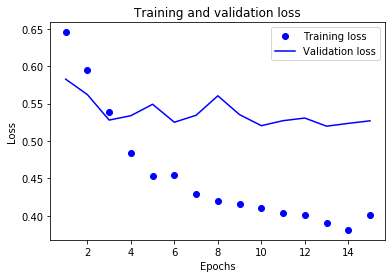

In [18]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

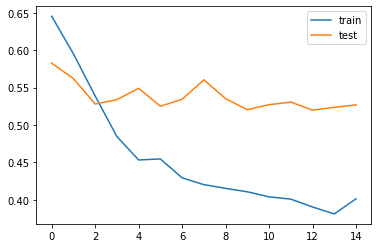

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

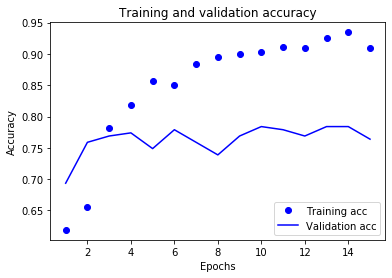

In [20]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

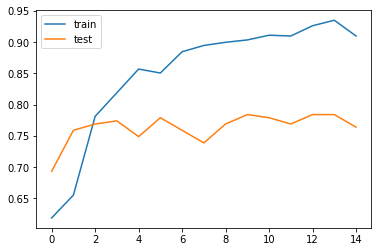

In [21]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend();

# Predictions

In [22]:
y_pred = model.predict(X_test[1:2])

In [23]:
print(y_pred[0])
print("Non sarcasm" if y_pred[0][0]>y_pred[0][1] else "Sarcasm")

[0.07958283 0.92041713]
Sarcasm


In [24]:
#https://stackoverflow.com/questions/32759712/how-to-find-the-closest-word-to-a-vector-using-word2vec

for x in range(1,2):
    print("---------TWEET " + str(x))
    for y in range(max_tweet_length):
        if((X_test[x][y]!=np.zeros(vector_size)).all()):
            print(word2vec.most_similar([ X_test[x][y] ], [], 1))

---------TWEET 1


NameError: name 'word2vec' is not defined

In [ ]:
word2vec.wv['almost']